### Задача

Есть данные до 2016 года по продажам компьютерных игр. Нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

### Оглавление

[1. Открытие и изучение данных](#1.-Открытие-и-изучение-данных)  
[2. Подготовка данных](#2.-Подготовка-данных)  
&nbsp;&nbsp;&nbsp;&nbsp;[2.1 Замена названий столбцов](#2.1-Замена-названий-cтолбцов)  
&nbsp;&nbsp;&nbsp;&nbsp;[2.2 Преобразование данных к нужным типам](#2.2-Преобразование-данных-к-нужным-типам)  
&nbsp;&nbsp;&nbsp;&nbsp;[2.3 Обработка пропусков](#2.3-Обработка-пропусков)  
&nbsp;&nbsp;&nbsp;&nbsp;[2.4 Расчёты](#2.4-Расчёты)  
[3. Исследовательский анализ данных](#3.-Исследовательский-анализ-данных)  
[4. Составим портрет пользователя каждого региона](#4.-Составим-портрет-пользователя-каждого-региона)  
&nbsp;&nbsp;&nbsp;&nbsp;[4.1 Определение самых популярных платформ](#4.1-Определение-самых-популярных-платформ)  
&nbsp;&nbsp;&nbsp;&nbsp;[4.2 Определение самых популярных жанров](#4.2-Определение-самых-популярных-жанров)  
&nbsp;&nbsp;&nbsp;&nbsp;[4.3 Определение влияния рейтинга ESRB на продажи](#4.3-Определение-влияния-рейтинга-ESRB-на-продажи)  
[5. Проверка гипотез](#5.-Проверка-гипотез)  
&nbsp;&nbsp;&nbsp;&nbsp;[5.1 Средние пользовательские рейтинги платформ XOne и PC одинаковые](#5.1-Средние-пользовательские-рейтинги-платформ-XOne-и-PC-одинаковые)  
&nbsp;&nbsp;&nbsp;&nbsp;[5.2 Средние пользовательские рейтинги жанров Action и Sports разные](#5.2-Средние-пользовательские-рейтинги-жанров-Action-и-Sports-разные)  
[6. Общий вывод](#6.-Общий-вывод)

### Импорт библиотек и настройки

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from matplotlib.colors import ListedColormap

warnings.filterwarnings('ignore')
sns.set(style='whitegrid')

### 1. Открытие и изучение данных

In [2]:
df = pd.read_csv('/datasets/games.csv')
df.sample(5)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
9333,The Guy Game,PS2,2004.0,Misc,0.07,0.05,0.00,0.02,48.0,6.7,M
1716,One Piece: Pirate Warriors,PS3,2012.0,Action,0.01,0.23,0.86,0.08,64.0,6.5,T
4920,Star Wars The Clone Wars: Republic Heroes,X360,2009.0,Action,0.18,0.17,0.00,0.04,43.0,6.3,T
4669,MLB 10: The Show,PS2,2010.0,Sports,0.20,0.16,0.00,0.05,NaN,tbd,E
9997,Deception IV: Blood Ties,PS3,2014.0,Action,0.03,0.02,0.06,0.01,70.0,8.2,M


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


### Вывод

В датафрейме 11 колонок, пропущенные значения есть в 6 колонках. Названия колонок содержат буквы разного регистра.  
Типы данных: `object`, `float64`. `Year_of_Release` и `User_Score` имеют неверный тип данных.  
`Critic_Score` и `User_Score` оцениваются по разным шкалам.

### 2. Подготовка данных

#### 2.1 Замена названий столбцов

In [4]:
df.columns = df.columns.str.lower()
df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

#### 2.2 Преобразование данных к нужным типам

Заменим тип данных колонки `user_score` с `object` на числовой `float64` и приведем оценки критиков и пользователей к единообразию. Для этого умножим 10-бальную шкалу на 10.

In [5]:
len(df[df['user_score'] == 'tbd'])

2424

Колонка с числами имеет тип `object` так как содержит `tbd`, что значит, что у игры меньше 4 отзывов, поэтому оценка не отображается. Это равнозначно отсутствию данных, поэтому меняем `tbd` на `NaN`

In [6]:
df['user_score'][df['user_score'] == 'tbd'] = np.nan
df['user_score'] = df['user_score'].astype(float)
df['user_score'] = df['user_score'] * 10
df['user_score']

0        80.0
1         NaN
2        83.0
3        80.0
4         NaN
         ... 
16710     NaN
16711     NaN
16712     NaN
16713     NaN
16714     NaN
Name: user_score, Length: 16715, dtype: float64

#### 2.3 Обработка пропусков

Два пропуска в колонке `name` и `genre` заполнить не можем, но и удалять не будем, чтобы использовать другие данные из этих строк. Пропуски могли появиться при выгрузке данных.

In [7]:
df[df['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Проверим колонку `year_of_release`.

In [8]:
df[df['year_of_release'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,85.0,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,64.0,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,79.0,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16373,PDC World Championship Darts 2008,PSP,NaN,Sports,0.01,0.00,0.00,0.00,43.0,NaN,E10+
16405,Freaky Flyers,GC,NaN,Racing,0.01,0.00,0.00,0.00,69.0,65.0,T
16448,Inversion,PC,NaN,Shooter,0.01,0.00,0.00,0.00,59.0,67.0,M
16458,Hakuouki: Shinsengumi Kitan,PS3,NaN,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN


269 пропусков могли появиться при выгрузке данных.  
Если игра выпускалась на нескольких платформах, то как правило, в один год, поэтому можем взять год с этой же игры на другой платформе.

In [9]:
def change(col):
    for el in df[(df[col].isna())]['name']:
        df_el = df[df['name'] == el]
        has_score = not df[df['name'] == el][col].isna().all()

        if len(df_el) > 1 and has_score:
            
            df[col].update(
                df_el[col].fillna(
                    round(df_el[~(df_el[col].isna())][col].mean(), 0)
                )
            )  

In [10]:
change('year_of_release') 

In [11]:
print('Пропусков в year_of_release:', len(df[df['year_of_release'].isna()]))

Пропусков в year_of_release: 146


139 пропусков. Оставляем их,чтобы использовать другие данные с этих строк. 

Проверим колонки `critic_score` и `user_score`.  
Пропуски в колонках `critic_score`, `user_score` могут быть, если игра выходила на нескольких платформах, при этом оценку проставили только для одной. Подразумевается, что на других платформах та же оценка, но по факту - пропуски.  

Заменим пропуски в колонке `critic_score`. Найдем игры с одинаковыми названиями и рассчитаем среднюю оценку критиков.

In [12]:
print(len(df[df['critic_score'].isna()]))
change('critic_score')
len(df[df['critic_score'].isna()])

8578


7617

Заменим пропуски в колонке `user_score`. Найдем игры с одинаковыми названиями и рассчитаем среднюю оценку пользователей.

In [13]:
print(len(df[df['user_score'].isna()]))
change('user_score')
len(df[df['user_score'].isna()])

9125


8026

Посмотрим, какие зависимости есть у колонки `critic_score` и `user_score`.

In [14]:
df.corr().style.background_gradient(cmap = 'coolwarm')

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score
year_of_release,1,-0.0928696,0.00380321,-0.168126,0.0375891,0.0195431,-0.249092
na_sales,-0.0928696,1,0.765335,0.449594,0.638649,0.231864,0.089688
eu_sales,0.00380321,0.765335,1,0.435061,0.722792,0.215129,0.0596219
jp_sales,-0.168126,0.449594,0.435061,1,0.291089,0.151288,0.129179
other_sales,0.0375891,0.638649,0.722792,0.291089,1,0.193473,0.0595961
critic_score,0.0195431,0.231864,0.215129,0.151288,0.193473,1,0.548687
user_score,-0.249092,0.089688,0.0596219,0.129179,0.0595961,0.548687,1


Наблюдается средняя корреляция только между `critic_score` и `user_score`. Для сохранения различий между данными не будем использовать эту закономерность. Больше существенных корреляций не наблюдается.

Проверим колонку `rating`.

In [15]:
len(df[df['rating'].isna()])

6766

Если данные подгружались из нескольких источников, то из-за несовпадения имени, часть может отсутствовать. Восстановить не можем. 

In [16]:
df['rating'].value_counts()

E       3990
T       2961
M       1563
E10+    1420
EC         8
K-A        3
RP         3
AO         1
Name: rating, dtype: int64

`K-A` - прошлая версия `E`. Заменим для едиообразия.

In [17]:
df['rating'].update(df[df['rating'] == 'K-A']['rating'].replace('K-A', 'E'))

In [18]:
df['rating'].value_counts()

E       3993
T       2961
M       1563
E10+    1420
EC         8
RP         3
AO         1
Name: rating, dtype: int64

#### 2.4 Расчёты

Посчитаем суммарные продажи во всех регионах.

In [19]:
df['sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']
df.head(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,80.0,E,82.54
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,83.0,E,35.52
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,80.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38


### Вывод

Названия столбцов скорректированы.  
Изменен тип данных колонки `user_score` с `object` на числовой `float64`.  
`tbd` заменены на `NaN` (равнозначны).  
Заполнены 130 пропусков в колонке `year_of_release`.  
Заполнены 961 пропусков в колонке  `critic_score`.  
Заполнены 1099 пропуска в колонке  `user_score`.  
Посчитаны суммарные продажи.

### 3. Исследовательский анализ данных

Посмотрим, сколько игр выпускалось в разные годы. 

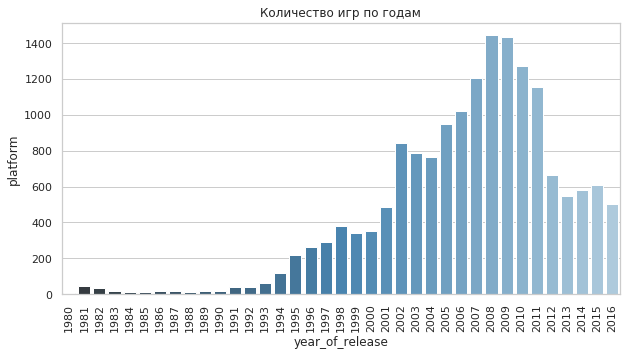

In [20]:
count_games = df.groupby(['year_of_release'])['platform'].count().reset_index()
count_games['year_of_release'] = count_games['year_of_release'].astype(int)


plt.subplots(figsize = (10,5))
plt.xticks(rotation=90)
plt.title('Количество игр по годам')
sns.barplot(
    data = count_games,
    x = 'year_of_release',
    y = 'platform',
    palette='Blues_d'
)

На графике - распределение Пуассона. С 2002 года по 2015 количество игр больше, чем за 2016 год. Пик пришелся на 2008-2009. В последние годы идет тренд на снижение. Значит в 2017 году количество может быть либо ниже, либо близко к значению 2016.

Посмотрим, как менялись продажи по платформам. 

In [21]:
#найдем 4 платформы с максимальной суммой продаж
top_platform = df.groupby(['platform'])['sales'].sum().reset_index().sort_values(by='sales', ascending=False).head(4)
top_platform

,platform,sales
16,PS2,1255.77
28,X360,971.42
17,PS3,939.65
26,Wii,907.51


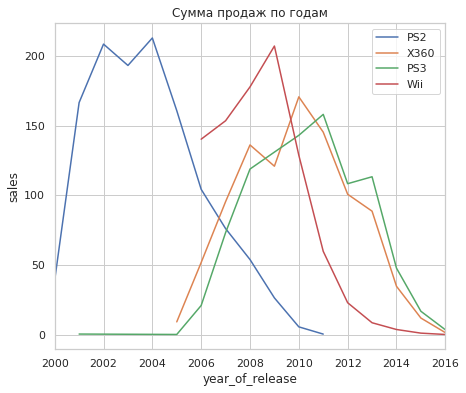

In [22]:
# построим линейный график сумм продаж по этим 4 платформам
f = plt.subplots(figsize=(7, 6))
for el in top_platform.values:
    df_platform = df[df['platform'] == el[0]]
    ax = df_platform.groupby(['year_of_release'])['sales'].sum().plot(legend=True)
    ax.set_ylabel('sales')
    ax.legend(top_platform['platform'].values.tolist()) 
    plt.title('Сумма продаж по годам')

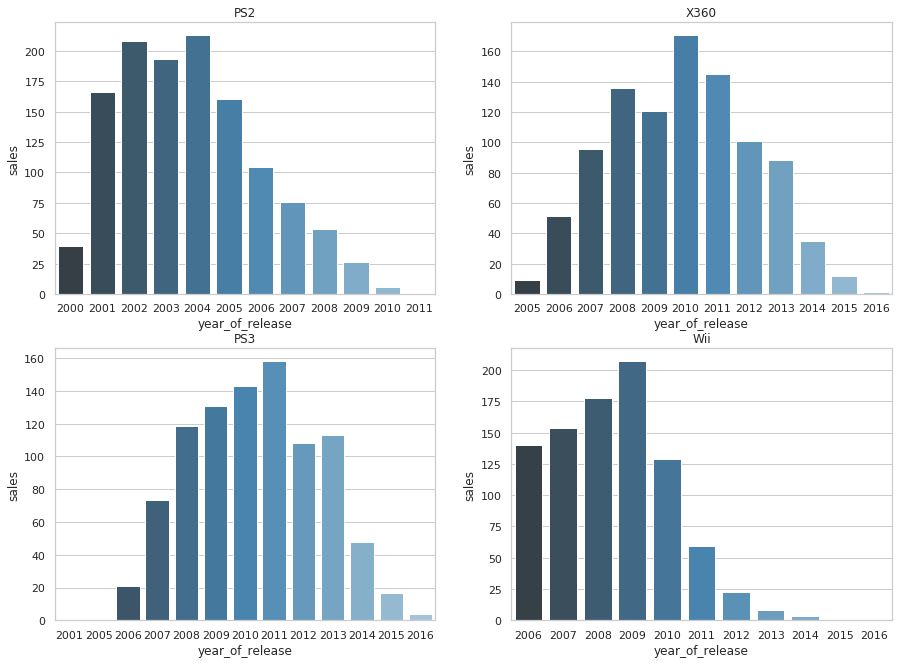

In [23]:
# построим столбчатые диаграммы сумм продаж по этим 4 платформам
fig = plt.figure(figsize=(15, 11))

for n, el in enumerate(top_platform.values):
    ax = fig.add_subplot(2,2,n + 1)
    
    df_platform = df[df['platform'] == el[0]].groupby(['year_of_release'])['sales'].sum().reset_index()
    df_platform['year_of_release'] = df_platform['year_of_release'].astype(int)
    sns.barplot(
        data=df_platform,
        x='year_of_release',
        y='sales',
        palette='Blues_d',
        ax=ax
    )
    plt.title(el[0])

На графиках отражены распределения Пуассона. Продажи больше 100 миллионов долларов сохраняются в течение 5-6 лет. На примере `PS` можно увидеть, что спустя 5 лет продажи `PS2` начинают падать, но пока еще приносят больше 100 млн, на 7 год выпускают новую версию - `PS3`. Спустя шесть лет начинают падать продажи `PS3`.  
Платформы набирают популярность 4-6 лет, а потом теряют позиции, так как пользователи выбирают новые модели.     

Выберем актуальный период, который отражает тенденции 2016 года - именно с 2012 года отсутствуют резкие перепады и видна общая тенденция, поэтому будем анализировать период с 2012 по 2016 год.

In [24]:
df_last_years = df[df['year_of_release'] >= 2012]

Посмотрим, какие платформы принесли больше всего прибыли за этот период.

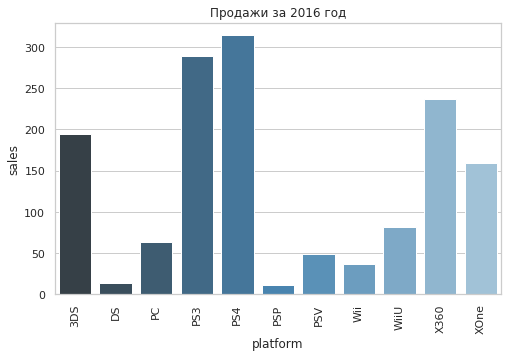

In [25]:
platform_sales = df_last_years.groupby(['platform'])['sales'].sum().reset_index()

plt.subplots(figsize = (8,5))
plt.xticks(rotation=90)
plt.title('Продажи за 2016 год')
sns.barplot(
    data = platform_sales,
    x = 'platform',
    y = 'sales',
    palette='Blues_d'
)

In [26]:
top_pl_period = platform_sales.sort_values(by='sales', ascending=False)['platform'].head(5).unique().tolist()

In [27]:
print('Топ 5 по прибыли:', top_pl_period)

Топ 5 по прибыли: ['PS4', 'PS3', 'X360', '3DS', 'XOne']


Проверим, на каком этапе находится каждая платформа. Для этого построим диаграммы сумм продаж по платформам.

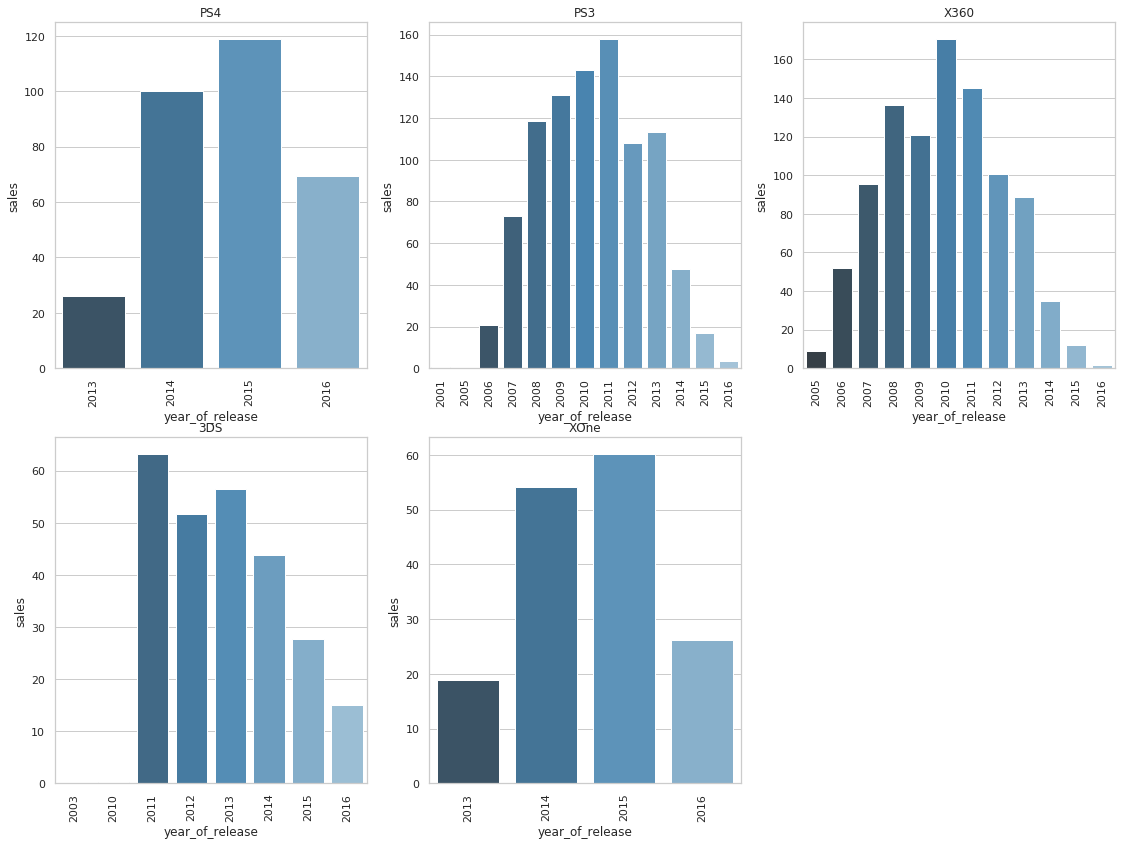

In [28]:
fig = plt.figure(figsize=(19, 14))

for n, el in enumerate(top_pl_period):
    ax = fig.add_subplot(2,3,n + 1)
    
    df_platform = df[df['platform'] == el].groupby(['year_of_release'])['sales'].sum().reset_index()
    df_platform['year_of_release'] = df_platform['year_of_release'].astype(int)
    sns.barplot(
        data=df_platform,
        x='year_of_release',
        y='sales',
        palette='Blues_d',
        ax=ax
    )
    plt.xticks(rotation=90)
    plt.title(el)

На графиках - распределение Пуассона. Все платформы перешли на падение.  
`PS3` и `X360` в последний год принесли уже меньше 10 млн.  
Только `PS4`, `XOne` и `3DS` принесли больше. У `PS4` и `XOne` 2016 год - первый год падения, а у `3DS` - четвертый.

Посмотрим информацию по глобальным продажам каждой игры и разбивкой по платформам.

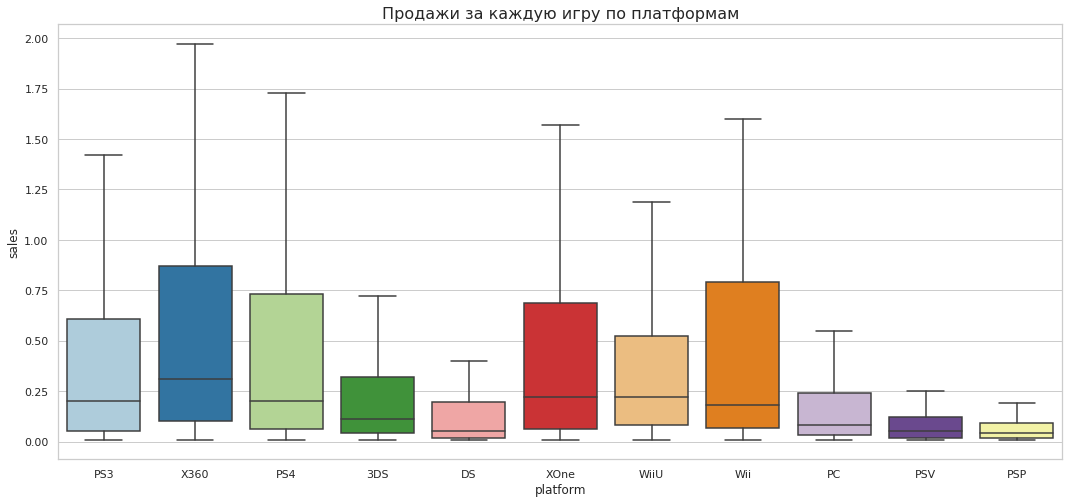

In [29]:
fig = plt.figure(figsize=(18, 8))
plt.title('Продажи за каждую игру по платформам', fontsize=16)

box = sns.boxplot(y='sales', x='platform', data=df_last_years, palette='Paired', showfliers = False)

По всем платформам датасет смещен вверх, медианное значение находится ближе к 1 квартилю.   
Диапазон прибыли больше всего у платформ: `X360`, `PS4` и `xOne`. Медианное значение - около 0,2 млн. На таких платформах можно получить больше прибыли, так как пользователи платят ощутимо больше медианных значений.  
Остальные платформы из топ 5 - `3DS` и `PS3` уступают по диапазону прибыли и максимальным значениям, при этом у `PS3`  показатели ближе к лидерам, а `3DS` отстает больше в том числе и по медианному значению, которое стремится к 0,1 млн.  

Посмотрим, как на продажи влияют отзывы пользователей и критиков. 

Оценим предполагаемые выгодные платформы: `PS4` и `XOne`.  
Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами. 

In [30]:
# данные по PS4
ps_df = df_last_years[df_last_years['platform'] == 'PS4'][['sales','critic_score','user_score']]
ps_df = ps_df.dropna()
ps_df

,sales,critic_score,user_score
42,12.62,97.0,83.0
77,8.58,82.0,43.0
92,7.66,83.0,57.0
94,7.60,85.0,50.0
105,7.17,87.0,65.0
...,...,...,...
16486,0.01,42.0,23.0
16499,0.01,70.0,68.0
16500,0.01,69.0,75.0
16526,0.01,61.0,79.0


Корреляция по данным `PS4`.

In [31]:
ps_df.corr()

,sales,critic_score,user_score
sales,1.000000,0.390521,-0.026261
critic_score,0.390521,1.000000,0.562445
user_score,-0.026261,0.562445,1.000000


Наблюдается слабая корреляция между продажами и оценками критиков. Линейной зависимости между продажами и оценками пользователей нет.

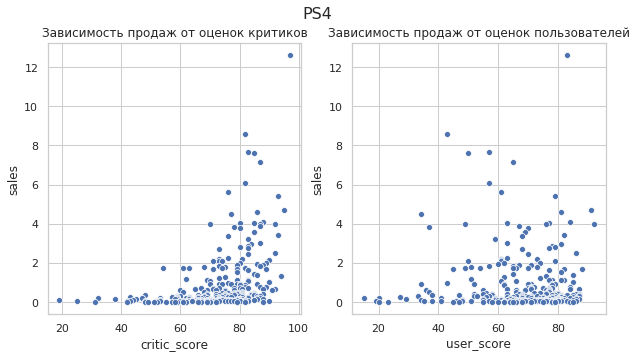

In [32]:
fig = plt.figure(figsize=(10,5))
fig.suptitle('PS4', fontsize=16)

ax1 = fig.add_subplot(1,2,1)
plt.title('Зависимость продаж от оценок критиков')
sns.scatterplot(data=ps_df, x='critic_score', y='sales', ax=ax1)

ax2 = fig.add_subplot(1,2,2)
plt.title('Зависимость продаж от оценок пользователей')
sns.scatterplot(data=ps_df, x='user_score', y='sales', ax=ax2)

На первом графике видно, что высоких продаж не было при низких оценках критиков. В среднем, рост продаж заметен от оценки 60. При этом у игр с оценкой критиков от 50 основные значения по продажам до 2 млн. Выше этого значения находится малая часть точек. Но если критики оценивали игру на более 95 баллов, то во всех случаях прибыль была уже выше 1 млн.  

На втором графике с пользовательской оценкой от 35 видны отдельные высокие значения прибыли. Основная масса точек также находится в районе оценки пользователей от 50 и низкой прибыли. При оценках от 90 прибыль составляет около 2 млн и выше.

In [33]:
# данные по XOne
xone_df = df_last_years[df_last_years['platform'] == 'XOne'][['sales','critic_score','user_score']]
xone_df = xone_df.dropna()
xone_df

,sales,critic_score,user_score
165,5.47,97.0,79.0
179,5.26,81.0,54.0
242,4.49,84.0,64.0
270,4.22,88.0,62.0
373,3.50,72.0,41.0
...,...,...,...
16597,0.01,65.0,60.0
16630,0.01,63.0,82.0
16643,0.01,64.0,66.0
16645,0.01,77.0,77.0


Корреляция по данным `XOne`.

In [34]:
xone_df.corr()

,sales,critic_score,user_score
sales,1.000000,0.372722,-0.091211
critic_score,0.372722,1.000000,0.470180
user_score,-0.091211,0.470180,1.000000


Наблюдается слабая корреляция между продажами и оценками критиков. Линейной зависимости между продажами и оценками пользователей нет.

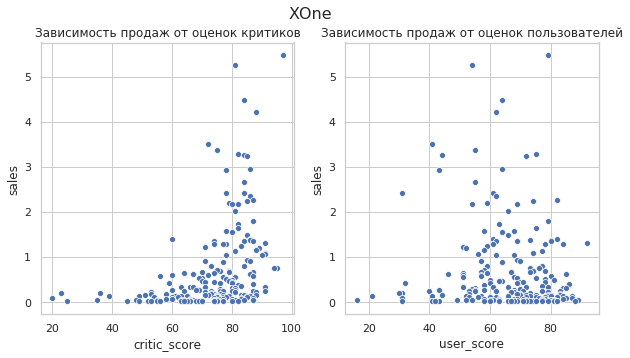

In [35]:
fig = plt.figure(figsize=(10,5))
fig.suptitle('XOne', fontsize=16)

ax1 = fig.add_subplot(1,2,1)
plt.title('Зависимость продаж от оценок критиков')
sns.scatterplot(data=xone_df, x='critic_score', y='sales', ax=ax1)

ax2 = fig.add_subplot(1,2,2)
plt.title('Зависимость продаж от оценок пользователей')
sns.scatterplot(data=xone_df, x='user_score', y='sales', ax=ax2)

На первом графике от оценки 50 начинается рост прибыли. Есть уникальные значения с высокими оценками и высокой прибылью. Основная часть точек имеет оценку от 50 и прибыль до 1 млн.  
На втором графике уникальные значения с высокой прибылью встречаются с оценкой от 30. Основная часть также имеет оценку от 50 и прибыль до 1 млн.   

Посчитаем корреляцию по всем данным.

In [36]:
df_last_years[['sales','critic_score','user_score']].corr()

,sales,critic_score,user_score
sales,1.000000,0.291722,0.013394
critic_score,0.291722,1.000000,0.457161
user_score,0.013394,0.457161,1.000000


В целом, графики по 2 платформам отражают одну картину, что согласуется с посчитанной корреляцией:  
зависимость продаж от оценок критиков линейная, слабая - точки углом занимают правую нижнюю часть графика;  
зависимость продаж от оценок пользователей отсутствует - точки занимают график неупорядоченно. 

Проанализируем продажи игр по жанрам. 

In [37]:
df_last_years.groupby('genre')['sales'].sum().sort_values(ascending=False)

genre
Action          446.41
Shooter         304.75
Role-Playing    192.80
Sports          181.07
Misc             85.28
Platform         61.00
Racing           53.50
Fighting         44.49
Simulation       35.12
Adventure        29.43
Strategy         13.34
Puzzle            4.89
Name: sales, dtype: float64

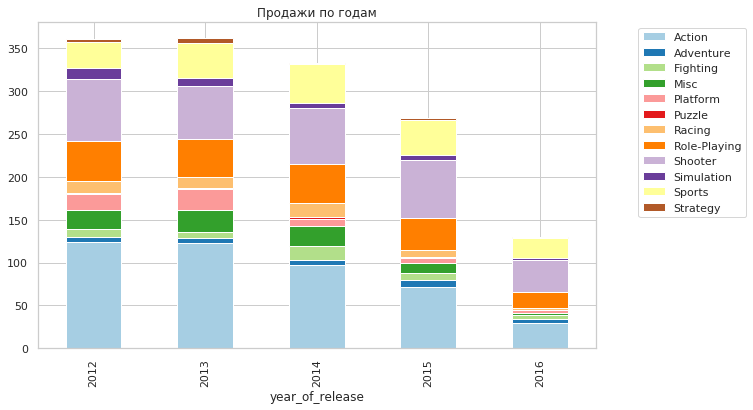

In [38]:
actual_bar = df_last_years.pivot_table(index=['year_of_release'], columns='genre', values='sales', aggfunc='sum')
actual_bar.index = actual_bar.index.astype(int)

actual_bar.plot(kind='bar', stacked=True, colormap=ListedColormap(sns.color_palette('Paired', 12)), figsize=(10, 6))
plt.title('Продажи по годам')
plt.legend(loc='best', bbox_to_anchor=(1.28, 1))

`Action` является одним из самых выгодных жанров и приносит прибыли больше, чем остальные. Одним из основных конкурентов этому жанру был `Shooter`. В последний год он стал самым прибыльным жанром.  Выделяются также `Sports`и `Role-Playing`: они тоже приносят весомую прибыль.  
По датасету это самые прибыльные жанры. В последний год они сильно потеряли прибыль, но сумма все еще больше, чем у остальных.

### Вывод

С 2008 года идет тренд на снижение по количеству и сумме покупок.  

Платформы набирают популярность 4-6 лет, а потом теряют позиции, так как пользователи выбирают новые модели.  
Топ 5 по прибыли: `PS4`, `PS3`, `X360`, `3DS`, `XOne`.
Диапазон прибыли и медианное значение больше всего у платформ: `X360`, `PS4` и `xOne`. `3DS`, `PS3` отстают по показателям.  
Из топ 5 выделяются `PS4`, `XOne` и `3DS`, так как они принесли больше 10 млн за последний год. У всех платформ тренд на снижение суммы покупок: у `PS4` и `XOne` 2016 год - первый год падения, а у `3DS` - четвертый. 

Самые прибыльные жанры - `Action`, `Shooter`, `Role-Playing` и `Sports`.  

Зависимость продаж от оценок критиков линейная, слабая, а зависимость продаж от оценок пользователей отсутствует. 

### 4. Составим портрет пользователя каждого региона

#### 4.1 Определение самых популярных платформ

In [39]:
# создадим функцию по созданию таблицы с самыми популярными платформами по данным за актуальный период 2012-2016 гг.
def table_sales(col_region, col_group):
    return (df_last_years.groupby(col_group)[col_region]
                .sum()
                .reset_index()
                .sort_values(by=col_region, ascending=False)
                .head(5))    

Создадим таблицы для пользователя каждого региона.

In [40]:
na_top_platform = table_sales('na_sales', 'platform')
na_top_platform

,platform,na_sales
9,X360,140.57
4,PS4,108.74
3,PS3,103.74
10,XOne,93.12
0,3DS,55.49


In [41]:
eu_top_platform = table_sales('eu_sales', 'platform')
eu_top_platform

,platform,eu_sales
4,PS4,141.09
3,PS3,107.27
9,X360,74.89
10,XOne,51.59
0,3DS,42.83


In [42]:
jp_top_platform = table_sales('jp_sales', 'platform')
jp_top_platform

,platform,jp_sales
0,3DS,87.79
3,PS3,35.29
6,PSV,21.04
4,PS4,15.96
8,WiiU,13.01


Построим круговые диаграммы. 

In [43]:
def create_pies(list_table, col):
    fig = plt.figure(figsize=(15, 5))
    
    legends = df_last_years[col].unique().tolist()
    palette = sns.color_palette('Paired', len(legends))
    colors = {i:j for i, j in zip(legends, palette)}
    handles = {}

    for n, el in enumerate(list_table):
        ax = fig.add_subplot(1,3,n + 1)
        
        el.plot(
            kind='pie', 
            autopct='%1.2f%%', 
            labels=el[col], 
            y=el.columns[1], 
            ax=ax, 
            colors=[colors[i] for i in el[col].values],
            legend=False
        )
        
        ax.set_title(el.columns[1], fontsize=16)
        ax.set_ylabel('')
        
        ax_handles, ax_labels = ax.get_legend_handles_labels()
        for handle, label in zip(ax_handles, ax_labels):
            handles[label] = handle
    
    fig.legend(handles.values(), handles.keys(), ncol=len(handles.keys()), loc='lower center')

In [44]:
list_table = [na_top_platform, eu_top_platform, jp_top_platform]

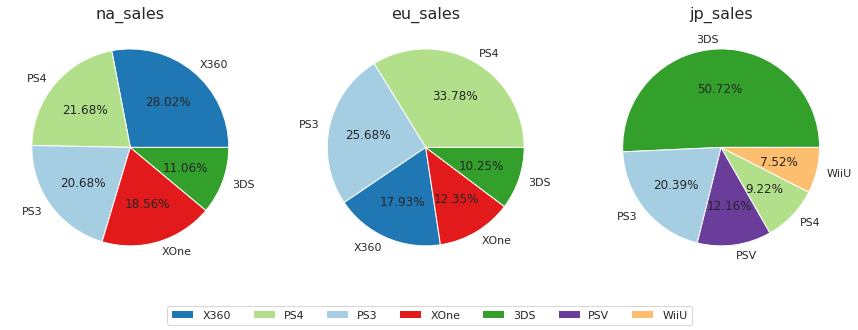

In [45]:
create_pies(list_table, 'platform')

Топ 5 в 2016 году совпадает в регионах __NA__ и __EU__, отличаясь в позициях платформ. Все три выделенные в 3 пункте платформы  популярны. `PS4` приносит 22% и 34%, а `XOne` - 19% и 12%. `3DS` приносит около 10%. Общая доля выделенных платформ в этих регионах - больше 50%.

В регионе __JP__ несколько иная картина: в топ 5 попали только 3 платформы, выгодные в __NA__ и __EU__, поэтому отличаются не только позиции, но и платформы. Здесь иной рынок, где 50% прибыли приносит платформа `3DS`, `PS4` приносит почти 10% прибыли. `XOne` здесь не пользуется популярностью.

#### 4.2 Определение самых популярных жанров

Создадим таблицы для пользователя каждого региона.

In [46]:
na_top_genre = table_sales('na_sales', 'genre')
na_top_genre

,genre,na_sales
0,Action,180.15
8,Shooter,144.79
10,Sports,81.53
7,Role-Playing,64.00
3,Misc,38.19


In [47]:
eu_top_genre = table_sales('eu_sales', 'genre')
eu_top_genre

,genre,eu_sales
0,Action,161.70
8,Shooter,113.47
10,Sports,69.09
7,Role-Playing,48.53
6,Racing,27.29


In [48]:
jp_top_genre = table_sales('jp_sales', 'genre')
jp_top_genre

,genre,jp_sales
7,Role-Playing,65.44
0,Action,52.80
3,Misc,13.10
9,Simulation,10.41
2,Fighting,9.44


Построим круговые диаграммы. 

In [49]:
list_table_genre = [na_top_genre, eu_top_genre, jp_top_genre]

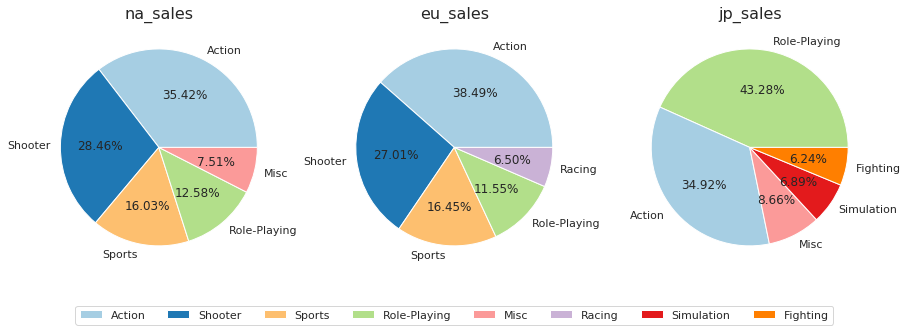

In [50]:
create_pies(list_table_genre, 'genre')

Ранее выделенные топовые жанры находятся на первых позициях в __NA__ и __EU__ с разницей в процентах. Общий лидер - `Action` (больше 35%). Только на последнем месте находятся разные платформы.  
В __JP__ вкусы другие. Лидер - `Role-Playing` (43%), далее `Action` (35%), остальная тройка приносит по 6-8%. `Sports` и `Shooter` не популярны.

#### 4.3 Определение влияния рейтинга `ESRB` на продажи

Создадим таблицы для пользователя каждого региона.


In [51]:
na_top_rating = table_sales('na_sales', 'rating')
na_top_rating

,rating,na_sales
2,M,231.67
0,E,114.37
1,E10+,77.93
3,T,66.02


In [52]:
eu_top_rating = table_sales('eu_sales', 'rating')
eu_top_rating

,rating,eu_sales
2,M,194.44
0,E,113.03
1,E10+,57.25
3,T,52.96


In [53]:
jp_top_rating = table_sales('jp_sales', 'rating')
jp_top_rating

,rating,jp_sales
0,E,28.33
3,T,26.02
2,M,21.20
1,E10+,8.19


Построим круговые диаграммы. 

In [54]:
list_table_rating = [na_top_rating, eu_top_rating, jp_top_rating]

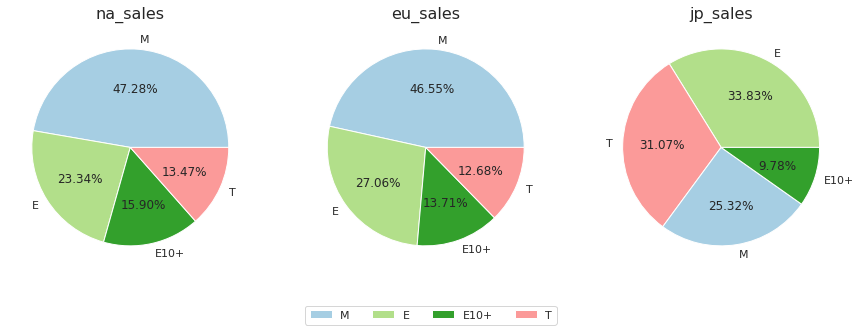

In [55]:
create_pies(list_table_rating, 'rating')

В __NA__ и __EU__  топ включает в себя одинаковые рейтинги, где самые выгодные игры для взрослых (`M`). На последнем месте - игры с рейтингом `T`.  
В __JP__ на первом месте - `E` (6+) c 34%. Далее непопуляный в других регионах рейтинг `T` (31%). И только на третьем месте рейтинг `M` с 25%.

### Вывод

В регионах __NA__ и __EU__ похожие результаты. В __JP__ рынок отличается.  
В регионах __NA__ и __EU__ больше 50% продаж приносят `PS4` и `XOne`, __JP__ - `3DS`.  
В регионах __NA__ и __EU__ около 80% продаж приносят `Shooter`, `Sports` и `Action`. В __JP__ около 80% приносят `Action` и `Role-Playing`.  
В регионах __NA__ и __EU__ около 70% продаж приносят игры с рейтингом `M` и `E`. В __JP__ 65% приходятся на рейтинг `E` и `T`.

### 5. Проверка гипотез

#### 5.1 Средние пользовательские рейтинги платформ `XOne` и `PC` одинаковые

Посмотрим на описание выборок `XOne` и `PC`.

In [56]:
df_last_years[df_last_years['platform'] == 'XOne']['user_score'].describe()

count    206.000000
mean      66.043689
std       13.781679
min       16.000000
25%       58.000000
50%       68.000000
75%       77.000000
max       92.000000
Name: user_score, dtype: float64

In [57]:
df_last_years[df_last_years['platform'] == 'PC']['user_score'].describe()

count    215.000000
mean      64.483721
std       16.654501
min       14.000000
25%       55.000000
50%       68.000000
75%       77.000000
max       93.000000
Name: user_score, dtype: float64

В обоих случаях среднее значение ниже медианы, значит на него влияют самые низкие оценки. Разница в пределах 5 баллов. Среднее `XOne` - 66 баллов, среднее `PC` - 70 баллов. Проверим значима ли разница в 4 балла. Для проверки будем использовать гипотезу о равенстве средних. 

Нулевая гипотеза - средние пользовательские рейтинги платформ `XOne` и `PC` одинаковые.  
Альтернативная гипотеза - средние пользовательские рейтинги платформ `XOne` и `PC` различны.  
Уровень значимости выберем 1% - ошибка возможна в 1 из 100 случаев.

In [58]:
alpha = 0.01
xone_user_score = df_last_years[df_last_years['platform'] == 'XOne']['user_score'].dropna().values 
pc_user_score = df_last_years[df_last_years['platform'] == 'PC']['user_score'].dropna().values
 
results = st.ttest_ind(xone_user_score, pc_user_score) 
 
print('p-значение: ', results.pvalue) 
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не можем отвергнуть нулевую гипотезу')

p-значение:  0.29678747792068083
Не можем отвергнуть нулевую гипотезу


Вероятность показывает, что такое или большее отличие можно получить случайно. В данном случае p-значение выше порогового значения.
Гипотезу о равенстве средних отвергнуть не можем. Статистически значимых различий не найдено.

#### 5.2 Средние пользовательские рейтинги жанров `Action` и `Sports` разные

Посмотрим на описание выборок по жанрам `Action` и `Sports`.

In [59]:
df_last_years[df_last_years['genre'] == 'Action']['user_score'].describe()

count    610.000000
mean      68.622951
std       13.739380
min       16.000000
25%       62.250000
50%       72.000000
75%       78.000000
max       91.000000
Name: user_score, dtype: float64

In [60]:
df_last_years[df_last_years['genre'] == 'Sports']['user_score'].describe()

count    221.000000
mean      54.162896
std       16.945117
min        2.000000
25%       43.000000
50%       57.000000
75%       67.000000
max       88.000000
Name: user_score, dtype: float64

Медиана выше среднего, на среднее влияют минимальные значения. Среднее `Action` - 68.6, среднее `Sports` - 54.2. Проверим значима ли разница в 14.4 балла. Для проверки будем использовать гипотезу о равенстве средних. 

Нулевая гипотеза - средние пользовательские рейтинги жанров `Action` и `Sports` одинаковые.  
Альтернативная гипотеза - средние пользовательские рейтинги жанров `Action` и `Sports` различны.  
Уровень значимости выберем 1% - ошибка возможна в 1 из 100 случаев.

In [61]:
alpha = 0.01
action_user_score = df_last_years[df_last_years['genre'] == 'Action']['user_score'].dropna().values 
sports_user_score = df_last_years[df_last_years['genre'] == 'Sports']['user_score'].dropna().values
 
results = st.ttest_ind(action_user_score, sports_user_score) 
 
print('p-значение: ', results.pvalue) 
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не можем отвергнуть нулевую гипотезу')

p-значение:  2.8810949983489825e-33
Отвергаем нулевую гипотезу


В этом случае p-значение существенно ниже порогового значения. Гипотезу о равенстве средних отвергаем. Средние пользовательские рейтинги жанров `Action` и `Sports` различны.

### 6. Общий вывод

С 2008 года идет тренд на снижение по количеству и сумме покупок.  

Платформы набирают популярность 4-6 лет, а потом теряют позиции, так как пользователи выбирают новые модели.  
Топ 5 по прибыли за 2012-2016 гг.: `PS4`, `PS3`, `X360`, `3DS`, `XOne`. Из них выделяются `PS4`, `XOne` и `3DS`, так как они принесли больше 10 млн за последний год. У всех платформ тренд на снижение суммы покупок: у `PS4` и `XOne` 2016 год - первый год падения, а у `3DS` - четвертый.  

В регионах __NA__ и __EU__ больше 50% продаж приносят `PS4` и `XOne`, в __JP__ - `3DS`.  

Самые прибыльные жанры за 2012-2016 гг.: `Action`, `Shooter`, `Role-Playing` и `Sports`. За последний год максимальную прибыль принес `Shooter`.

В регионах __NA__ и __EU__ около 80% продаж приносят `Action`,`Shooter` и `Sports`. В __JP__ около 80% приносят `Action` и `Role-Playing`.

В регионах __NA__ и __EU__ около 70% продаж приносят игры с рейтингом `M` и `E`. В __JP__ 65% приходятся на рейтинг `E` и `T`.

Зависимость продаж от оценок критиков линейная, слабая, а зависимость продаж от оценок пользователей отсутствует.  

Средние пользовательские рейтинги жанров `Action` и `Sports` различны. Статистически значимых различий между средними пользовательскими рейтингами платформ `XOne` и `PC` не найдено.
